In [3]:
from platform import python_version
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pkg_resources
import sklearn
from scipy.fft import fft, fftfreq
from scipy.interpolate import BarycentricInterpolator as bc
from scipy.interpolate import UnivariateSpline
import pickle

In [5]:
iDF= pd.read_csv("./InsulinData.csv", low_memory=False)
cDF= pd.read_csv("./CGMData.csv", low_memory=False)

In [6]:
print(iDF.info())
print(cDF.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41435 entries, 0 to 41434
Data columns (total 47 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   Index                                41435 non-null  int64  
 1   Date                                 41435 non-null  object 
 2   Time                                 41435 non-null  object 
 3   New Device Time                      8 non-null      object 
 4   BG Reading (mg/dL)                   3737 non-null   float64
 5   Linked BG Meter ID                   0 non-null      float64
 6   Basal Rate (U/h)                     2022 non-null   float64
 7   Temp Basal Amount                    0 non-null      float64
 8   Temp Basal Type                      0 non-null      float64
 9   Temp Basal Duration (h:mm:ss)        0 non-null      float64
 10  Bolus Type                           29501 non-null  object 
 11  Bolus Volume Selected (U)   

In [7]:
mealsConsumed= list(iDF[iDF['BWZ Carb Input (grams)'].notna() & iDF['BWZ Carb Input (grams)'] != 0.0]['Time'][::-1])
mealsIndex= iDF[iDF['BWZ Carb Input (grams)'].notna() & iDF['BWZ Carb Input (grams)']!= 0.0].index[::-1].values

myFilterArr= []
for x in range(0, len(mealsIndex)):
    num= mealsIndex[x]
    
    check= True
    
    mealTime= iDF.iloc[num][['Date','Time']].values
    mealTime= pd.to_datetime(mealTime[0] + " " + mealTime[1] )
    
    while True:
        num= num-1
        r= iDF['BWZ Carb Input (grams)'].iloc[num]
        rmealTime= iDF[['Date', 'Time']].iloc[num].values
        rmealTime= pd.to_datetime(rmealTime[0] + " " + rmealTime[1] )
        
        if rmealTime >(mealTime + pd.Timedelta(2,"h")) or num<0:
            break
        if not np.isnan(r):
            check= False
            break
            
    if check:
        myFilterArr.append(mealsIndex[x])



In [8]:
print(len(myFilterArr)) #559 rowed Meal data matrix

559


In [9]:
print(len(mealsIndex))

747


In [16]:
carbArr= []
for x in myFilterArr:
    r= iDF['BWZ Carb Input (grams)' ].iloc[x]
    carbArr.append(r)
    
numBins= int(np.ceil((max(carbArr)-min(carbArr))/ 20 ))
print(numBins)

7


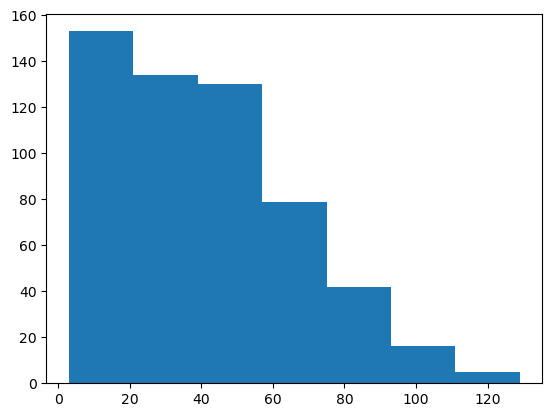

In [95]:
plt.hist(carbArr, bins= numBins)
plt.show()

In [17]:
binVals= [x for x in range(0,20 * (numBins),20) ]
print(binVals)

binList= [-10]
np.digitize(binList,binVals) 

[0, 20, 40, 60, 80, 100, 120]


array([0], dtype=int64)

In [21]:
mealList= []
groundTruth= [] 

for x in myFilterArr:
    r= iDF['BWZ Carb Input (grams)' ].iloc[x] 
    
    mealTime= iDF[['Date','Time']].iloc[x].values 
    mealTime= mealTime[0] + " " +mealTime[1] 
    mealTime= pd.to_datetime(mealTime)
    
    dVal= cDF[(pd.to_datetime(cDF['Date']).dt.date == mealTime.date())][["Date", "Time", "Sensor Glucose (mg/dL)" ]] 
    lVal= dVal[(pd.to_datetime(dVal['Time']).dt.time >=mealTime.time())]
    uVal= dVal[(pd.to_datetime(dVal['Time']).dt.time <= (mealTime + pd.Timedelta(5,"m")).time()) ] 
    
    if len(lVal) > 0 and len(uVal)> 0:
        lVal2= lVal.iloc[-1 ]
        uVal2= uVal.iloc[0]
        
        if uVal2.name == lVal2.name:
            index= uVal2.name
            mealList.append(list(cDF.iloc[index-20:index+4 ]['Sensor Glucose (mg/dL)'][::-1]) )
            groundTruth.append(np.digitize([r], binVals)[0]) 


C:\Users\15713\AppData\Local\Temp\ipykernel_3148\4058108316.py:12: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  lVal= dVal[(pd.to_datetime(dVal['Time']).dt.time >=mealTime.time())]
C:\Users\15713\AppData\Local\Temp\ipykernel_3148\4058108316.py:13: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  uVal= dVal[(pd.to_datetime(dVal['Time']).dt.time <= (mealTime + pd.Timedelta(5,"m")).time()) ]
C:\Users\15713\AppData\Local\Temp\ipykernel_3148\4058108316.py:12: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  lVal= dVal[(pd.to_datetime(dVal['Time']).dt.time >=mealTime.time())]
C:\Users

In [22]:
print(len(mealList))

553


In [26]:
print(mealList[0])
print(len(mealList[0]))

[71.0, 81.0, 102.0, 131.0, 140.0, 147.0, 153.0, 159.0, 163.0, 159.0, 153.0, 151.0, 155.0, 163.0, 164.0, nan, 166.0, 168.0, 164.0, 169.0, 178.0, 184.0, 190.0, 195.0]
24


In [27]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge

from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer

In [30]:
clearList= [] 
cNum= 0
for x in range(0, len(mealList) ):
    if np.isnan(mealList[x]).any(): 
    
        if np.count_nonzero(np.isnan(mealList[x])) > 10:
            pass
            
        clearList.append(x)
        cNum= cNum+1
        
print(f"{cNum} dirty")
print(f"{len(clearList)} to remove")
print(len(mealList))
print(clearList)

115 dirty
115 to remove
553
[0, 12, 13, 14, 15, 31, 32, 33, 41, 46, 47, 64, 74, 78, 79, 81, 82, 97, 98, 100, 112, 118, 119, 140, 157, 176, 177, 188, 190, 192, 205, 206, 207, 208, 210, 211, 214, 226, 228, 229, 235, 239, 247, 252, 253, 254, 256, 258, 259, 260, 261, 279, 284, 285, 286, 290, 291, 298, 300, 318, 322, 323, 324, 325, 329, 335, 337, 338, 339, 341, 342, 343, 344, 364, 365, 366, 367, 368, 369, 370, 385, 386, 392, 393, 394, 395, 397, 399, 409, 411, 427, 428, 429, 441, 443, 444, 445, 446, 447, 451, 457, 469, 472, 473, 474, 489, 507, 508, 515, 524, 529, 533, 539, 542, 545]


In [31]:
for x in clearList[::-1]:
    mealList.pop(x)
    
#print(len(mealList))

438


[151.0, 154.0, 153.0, 158.0, 158.0, 160.0, 159.0, 164.0, 167.0, 166.0, 165.0, 164.0, 166.0, 167.0, 172.0, 174.0, 182.0, 186.0, 193.0, 194.0, 185.0, 184.0, 178.0, 180.0]
[151 154 153 158 158 160 159 164 167 166 165 164 166 167 172 174 182 186
 193 194 185 184 178 180]


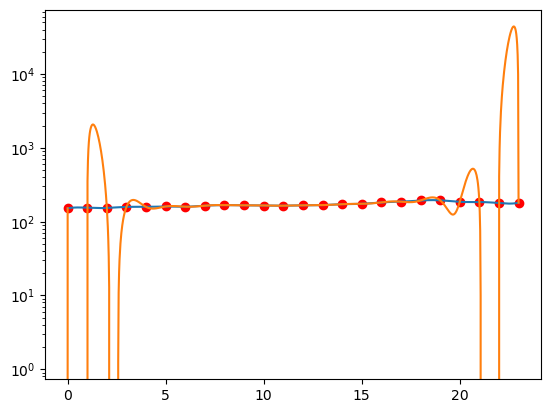

In [35]:
xValue= range(0,24) 
yValue= mealList[len(mealList)-1] 
yVal2= [int(xValue) if np.isnan(xValue) == False else xValue for xValue in yValue ] 
yVal2= np.array(yVal2)
#print(yValue)
#print(yVal2)

yForBC= bc(xValue, yValue)
yForspl = UnivariateSpline(xValue, yValue,s=0, k=4) 
plt.semilogy(xValue, yValue,'ro',label = 'data')
xSpace = np.linspace(xValue[0],xValue[-1],1000)

plt.semilogy(xSpace, yForspl(xSpace))
plt.semilogy(xSpace, yForBC(xSpace))

In [38]:
newYVal= np.interp(np.arange(len(yVal2) ),  
         np.arange(len(yVal2))[np.isnan(yVal2) == False ], 
         yVal2[np.isnan(yVal2 ) == False] )
print(list(newYVal))

[151.0, 154.0, 153.0, 158.0, 158.0, 160.0, 159.0, 164.0, 167.0, 166.0, 165.0, 164.0, 166.0, 167.0, 172.0, 174.0, 182.0, 186.0, 193.0, 194.0, 185.0, 184.0, 178.0, 180.0]


In [ ]:
y_spl_2d = y_spl.derivative(n=2)
print(y_spl_2d)
plt.plot(x_range,y_spl_2d(x_range))
plt.plot(3, color='r')

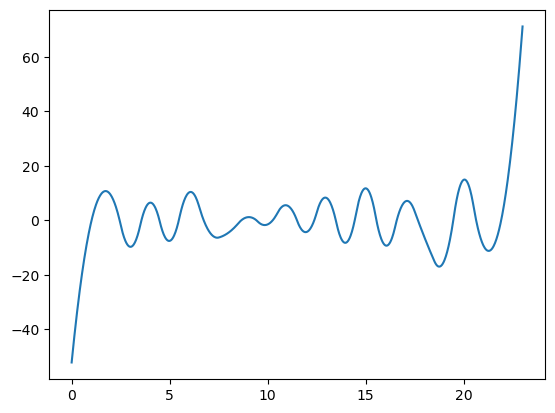

In [39]:
ySPL2= yForspl.derivative(n=2 )
print(ySPL2)
plt.plot(xSpace, ySPL2(xSpace) )
plt.plot(3, color= 'b')

In [40]:
yForspl.__call__(9, nu=2)

array(1.1569052)

[200.0, 199.0, 201.0, 201.0, 194.0, 188.0, 183.0, 181.0, 176.0, 170.0, 168.0, 169.0, 172.0, 179.0, 192.0, 203.0, 205.0, 210.0, 213.0, 212.0, 216.0, 213.0, 210.0, 210.0]
[176.90952043+1.79116369e+02j -63.44486373-4.20525589e+01j
   6.77817459+1.21923882e+01j -26.        -1.73205081e+00j
  -6.17737943+4.51475100e+00j  -4.        +1.70000000e+01j
   2.84278825-1.50657818e-01j   0.        +1.21243557e+01j
  -8.77817459+6.19238816e+00j  -4.55513627-3.94744112e+00j
  -3.57492925-2.21822170e+00j  -5.        -0.00000000e+00j
  -3.57492925+2.21822170e+00j  -4.55513627+3.94744112e+00j
  -8.77817459-6.19238816e+00j   0.        -1.21243557e+01j
   2.84278825+1.50657818e-01j  -4.        -1.70000000e+01j
  -6.17737943-4.51475100e+00j -26.        +1.73205081e+00j
   6.77817459-1.21923882e+01j -63.44486373+4.20525589e+01j
 176.90952043-1.79116369e+02j]


C:\Users\15713\anaconda3\Lib\site-packages\matplotlib\cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
C:\Users\15713\anaconda3\Lib\site-packages\matplotlib\cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


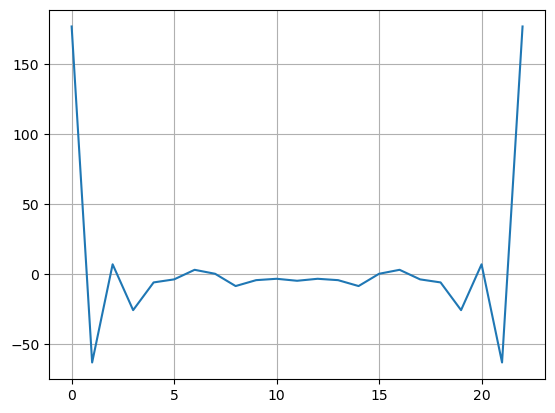

176
0


C:\Users\15713\AppData\Local\Temp\ipykernel_3148\1888682020.py:8: ComplexWarning: Casting complex values to real discards the imaginary part
  print(int(np.max(qfft)))


In [43]:
q= mealList[2]
print(q)
qfft= fft(q)[1:]
print(qfft)
plt.plot(qfft)
plt.grid()
plt.show()
print(int(np.max(qfft)))
print(np.argmax(qfft))

In [46]:
class createMatrix:
    def __init__(self):
        self.idf1= pd.read_csv("./InsulinData.csv" )
        self.cdf1= pd.read_csv("./CGMData.csv")

    def insulinS(self, iDF):
        myIndexes = iDF[iDF['BWZ Carb Input (grams)'].notna() & iDF['BWZ Carb Input (grams)'] != 0.0].index[::-1].values
        myFilter= []
        for x in range(0, len(myIndexes) ):
        
            indVal= myIndexes[x]
            aI= True
            dVal= iDF.iloc[indVal][['Date', 'Time']].values
            dVal = pd.to_datetime(dVal[0] + " " + dVal[1] )
            
            while True:
                indVal= indVal-1
                r= iDF['BWZ Carb Input (grams)'].iloc[indVal]
                rVal= iDF[['Date', 'Time']].iloc[indVal].values
                rVal= pd.to_datetime(rVal[0] + " " + rVal[1] )
                if rVal > (dVal + pd.Timedelta(2, "h" )) or indVal < 0:
                    break
                if not np.isnan(r):
                    aI = False
                    break
                    
            if aI:
                myFilter.append(myIndexes[x])
                
        return myFilter

    def makeMatrix(self, iDF, cDF):
        m= []
        cV= np.ndarray(shape=(0,1), dtype=np.intc)
        myFilter= self.insulinS(iDF)
        carbVal= []
        for ind in myFilter:
            r= iDF['BWZ Carb Input (grams)'].iloc[ind ] 
            carbVal.append(r)
        nu= int(np.ceil((max(carbVal) - min(carbVal)) / 20))
        binz= [x for x in range(0, 20 * (nu), 20 ) ]
        for i in myFilter:
            r= iDF['BWZ Carb Input (grams)'].iloc[i] 
            dVal= iDF[['Date','Time']].iloc[i].values
            dVal= dVal[0] + " "+ dVal[1]
            dVal= pd.to_datetime(dVal)
            dVal2= cDF[(pd.to_datetime(cDF['Date']).dt.date == dVal.date() )][["Date", "Time", "Sensor Glucose (mg/dL)"] ]
            lVal= dVal2[(pd.to_datetime(dVal2['Time']).dt.time >= dVal.time())]
            uVal= dVal2[(pd.to_datetime(dVal2['Time']).dt.time <= (dVal + pd.Timedelta(5, "m" )).time())]
            if len(lVal) > 0 and len(uVal) > 0:
                l= lVal.iloc[-1]
                u= uVal.iloc[0]
                if u.name == l.name:
                    ind= u.name
                    m.append(list(cDF.iloc[ind-20:ind+4]['Sensor Glucose (mg/dL)'][::-1]) )
                    cV= np.vstack([cV, [np.digitize([r], binz)]] )
        return m, cV 
       
    def shapes(self, mat, cV):
        lose= []
        for i in range(0,len(mat)):
            if np.isnan(mat[i]).any():
            
                if np.count_nonzero(np.isnan(mat[i]) ) > 10:
                    lose.append(i)
                    
                else:
                    r= [int(x) if np.isnan(x) == False else x for x in mat[i] ]
                    yN= np.array(r)
                    newYz = np.interp(np.arange(len(yN)), 
                            np.arange(len(yN))[np.isnan(yN) == False ], 
                            yN[np.isnan(yN) == False])
                    mat[i]= list(newYz)
                    
        for i in lose[::-1]:
            mat.pop(i)
            cV= np.delete(cV, i)
        
        return np.array(mat, dtype= np.intc),  cV.reshape(len(cV), 1)
    
    def combine(self, mOne, mTwo):
        return np.concatenate((mOne, mTwo)) 

    
    def begin(self):
        print("Making Matricies")
        pFirst, pSecond = self.makeMatrix(self.idf1, self.cdf1)
        print("Cleaning")
        myMatrix, myMatrix2= self.shapes(pFirst, pSecond )
        print("Complete")
        return myMatrix, myMatrix2

In [47]:
cMatrix= createMatrix()
cM1, cM2= cMatrix.begin()

C:\Users\15713\AppData\Local\Temp\ipykernel_3148\2449394671.py:3: DtypeWarning: Columns (13,43) have mixed types. Specify dtype option on import or set low_memory=False.
  self.idf1= pd.read_csv("./InsulinData.csv" )
C:\Users\15713\AppData\Local\Temp\ipykernel_3148\2449394671.py:4: DtypeWarning: Columns (32) have mixed types. Specify dtype option on import or set low_memory=False.
  self.cdf1= pd.read_csv("./CGMData.csv")


Making Matricies


C:\Users\15713\AppData\Local\Temp\ipykernel_3148\2449394671.py:48: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  lVal= dVal2[(pd.to_datetime(dVal2['Time']).dt.time >= dVal.time())]
C:\Users\15713\AppData\Local\Temp\ipykernel_3148\2449394671.py:49: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  uVal= dVal2[(pd.to_datetime(dVal2['Time']).dt.time <= (dVal + pd.Timedelta(5, "m" )).time())]
C:\Users\15713\AppData\Local\Temp\ipykernel_3148\2449394671.py:48: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  lVal= dVal2[(pd.to_datetime(dVal2['Time']).dt.time >= dVal.time())]
C:\Users\15

Cleaning
Complete


C:\Users\15713\AppData\Local\Temp\ipykernel_3148\2449394671.py:49: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  uVal= dVal2[(pd.to_datetime(dVal2['Time']).dt.time <= (dVal + pd.Timedelta(5, "m" )).time())]
C:\Users\15713\AppData\Local\Temp\ipykernel_3148\2449394671.py:48: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  lVal= dVal2[(pd.to_datetime(dVal2['Time']).dt.time >= dVal.time())]
C:\Users\15713\AppData\Local\Temp\ipykernel_3148\2449394671.py:49: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  uVal= dVal2[(pd.to_datetime(dVal2['Time']).dt.time <= (dVal + pd.Timedelta(5, "

In [48]:
class featureExtractor:
    def __init__(self, df):
        self.df = df
    
    def f1(self, val):
        minimal= min(val[0:7] )
        maximal= max(val[7:])
        return np.where(val == maximal )[0][0] - np.where( val == minimal)[0][0]
    
    def f2(self, val):
        minimal= min(val[0:7])
        maximal= max(val[7:])
        return (maximal - minimal)/minimal
    
    def f3(self, val):
        ySpl= UnivariateSpline(range(0,24), val, s=0, k=4)
        return ySpl.__call__(np.where( val == min(val[0:7]))[0][0], nu=1 )
    
    def f4(self, val): 
        ySpl= UnivariateSpline(range(0,24), val, s=0, k=4 )
        return ySpl.__call__(np.where(val == min(val[0:7]))[0][0], nu=2)
    
    def f5(self, val):
        yFi= fft(val)[1:]
        return np.longdouble(np.max(yFi) )

    def f6(self, val): 
        yFi= fft(val)[1:]
        return np.argmax(yFi)
        
    def f7(self, val): 
        return np.mean(val)
        
    def f8(self, val): 
        return np.std(val )
    
    def extract(self):
        mArr= np.ndarray(shape=(0,8), dtype= np.intc )
        for x in self.df:
            mArr= np.vstack([mArr, np.array([self.f1(x), self.f2(x), self.f3(x), self.f4(x), self.f5(x), self.f6(x), self.f7(x), self.f8(x)])])
        return mArr

In [51]:
mealFeatures= featureExtractor(cM1)
mFeatures= mealFeatures.extract()
print(mFeatures)

C:\Users\15713\AppData\Local\Temp\ipykernel_3148\970783372.py:25: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.longdouble(np.max(yFi) )


[[ 23.           1.74647887  18.71372945 ...   5.         152.95833333
   29.74401784]
 [ 12.           0.25909091  -4.18824165 ...   0.         248.125
   20.0734329 ]
 [ 10.           2.3         39.05770068 ...  13.          87.20833333
   25.1246545 ]
 ...
 [ 23.           0.93269231  13.40026613 ...   1.         156.58333333
   24.74691339]
 [ 11.           2.14634146  -7.99144204 ...  21.          79.5
   28.6618213 ]
 [ 19.           0.28476821  18.72483539 ...   8.         170.
   12.36931688]]


In [52]:
mealFeaturesLabels= np.concatenate((mFeatures, cM2), axis=1 )
print(mealFeaturesLabels)

[[ 23.           1.74647887  18.71372945 ... 152.95833333  29.74401784
    6.        ]
 [ 12.           0.25909091  -4.18824165 ... 248.125       20.0734329
    4.        ]
 [ 10.           2.3         39.05770068 ...  87.20833333  25.1246545
    4.        ]
 ...
 [ 23.           0.93269231  13.40026613 ... 156.58333333  24.74691339
    4.        ]
 [ 11.           2.14634146  -7.99144204 ...  79.5         28.6618213
    1.        ]
 [ 19.           0.28476821  18.72483539 ... 170.          12.36931688
    2.        ]]


In [57]:
myDF= pd.DataFrame(data=mealFeaturesLabels, columns=['F1','F2','F3','F4','F5','F6','F7','F8','Class'] )
print(myDF)

       F1        F2         F3          F4          F5    F6          F7  \
0    23.0  1.746479  18.713729  -41.890516  -53.000000   5.0  152.958333   
1    12.0  0.259091  -4.188242   19.390328  204.435384   0.0  248.125000   
2    10.0  2.300000  39.057701  -60.233443  -11.215390  13.0   87.208333   
3    14.0  0.180328  -3.175932    5.081660  176.909520   0.0  194.375000   
4    11.0  0.745902  -2.021605    7.058327   58.971143   1.0  169.875000   
..    ...       ...        ...         ...         ...   ...         ...   
493  20.0  1.824324  74.012331 -133.910838   28.421296   0.0  149.958333   
494   5.0  0.100000   0.234705   -4.728158  140.210236  21.0  199.875000   
495  23.0  0.932692  13.400266   28.495570   76.514083   1.0  156.583333   
496  11.0  2.146341  -7.991442   16.721186   59.042940  21.0   79.500000   
497  19.0  0.284768  18.724835  -52.163533   -6.878680   8.0  170.000000   

            F8  Class  
0    29.744018    6.0  
1    20.073433    4.0  
2    25.124655 

In [61]:
np.random.seed(42)

xformyDF= myDF[['F3','F4'] ].copy()
yformyDF= myDF['Class'].copy()

In [59]:
#print(yformyDF[0])

6.0


In [60]:
from sklearn.cluster import KMeans

In [64]:
from sklearn.metrics import mean_squared_error

trainVal= []

for x in range(1,256):
    bArr= format(x, '8b' )
    fArr=[]
    
    if bArr[0] == '1':
        fArr.append('F8') 
        
    if bArr[1] == '1':
        fArr.append('F7') 
        
    if bArr[2] == '1':
        fArr.append('F6') 
        
    if bArr[3] == '1':
        fArr.append('F5') 
        
    if bArr[4] == '1':
        fArr.append('F4') 
        
    if bArr[5] == '1':
        fArr.append('F3') 
        
    if bArr[6] == '1':
        fArr.append('F2') 
        
    if bArr[7] == '1':
        fArr.append('F1')
        
    trainingVals= myDF[fArr].copy()
    kmTest= KMeans(n_clusters= 7, init= 'random', n_init= 20, random_state= 42 ).fit(trainingVals )
    kmSSE = int(len(yformyDF) * mean_squared_error(yformyDF, kmTest.labels_ + 1 ))
    trainVal.append(kmSSE)
    
print(trainVal)

C:\Users\15713\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\Users\15713\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\Users\15713\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\Users\15713\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Window

[4327, 2456, 3524, 3295, 2157, 3295, 2194, 2280, 2738, 2276, 3353, 2644, 2316, 2644, 2316, 2469, 2473, 2469, 2473, 2453, 2452, 2453, 2452, 2731, 2725, 2731, 2725, 3972, 3975, 3972, 3975, 2898, 4148, 4599, 4114, 3398, 5090, 3398, 5100, 2306, 2318, 2306, 2318, 4553, 2450, 3027, 2450, 4713, 3800, 4713, 3800, 2446, 2444, 2446, 2444, 2707, 2716, 2707, 2716, 3990, 4027, 3990, 4027, 3296, 4202, 3296, 4202, 3572, 3569, 4321, 3569, 4076, 3941, 4076, 3941, 3994, 3994, 3994, 3994, 3221, 3229, 3221, 3229, 3221, 3229, 3221, 3229, 3059, 2996, 3059, 2996, 2633, 2633, 2633, 2633, 3869, 4023, 3869, 4023, 3598, 2304, 3598, 2304, 3666, 3690, 3666, 3690, 5082, 4076, 5082, 4076, 3229, 3229, 3229, 3229, 3229, 3229, 3229, 3229, 2962, 2651, 2962, 2651, 2623, 2640, 2623, 2640, 3520, 3945, 3520, 2967, 4779, 4722, 3632, 4722, 2446, 2493, 5257, 2493, 2306, 3337, 2306, 3253, 4396, 4384, 4396, 4384, 4107, 4106, 4099, 4106, 2706, 2712, 2706, 2712, 2742, 3091, 2742, 3091, 4378, 4435, 4378, 4451, 3836, 2950, 3841, 295

In [65]:
oP= np.array(trainVal)
print(np.min(oP) )
print( format(np.argmin(oP), '8b') )

2157
     100


In [67]:
kMean= KMeans(n_clusters= 7, init='random', n_init= 20, random_state= 42 ).fit(xformyDF)
kmeanPredict= kMean.labels_ + 1
print(kmeanPredict)

C:\Users\15713\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


[2 1 2 1 1 3 1 1 2 5 5 3 1 1 3 1 5 2 2 2 3 1 3 1 1 1 2 1 1 3 1 1 1 1 1 3 1
 1 1 1 1 1 1 1 1 1 5 1 1 1 1 1 1 3 1 2 2 1 5 5 1 1 1 1 1 1 1 1 1 1 2 1 1 7
 1 1 1 1 3 3 1 1 3 1 1 6 2 5 1 1 6 1 1 1 1 3 1 3 2 1 1 1 1 5 3 1 1 2 5 1 3
 1 1 1 1 3 1 5 1 1 5 3 1 3 1 1 3 1 1 1 1 1 1 1 7 1 3 2 5 1 3 1 1 1 3 1 1 1
 1 6 1 1 1 1 1 3 3 1 3 3 1 1 1 1 1 1 2 1 3 5 1 2 5 1 4 4 6 3 6 5 1 1 1 3 3
 3 1 1 1 1 1 1 5 6 5 1 3 1 1 1 3 5 1 1 3 3 1 1 5 1 1 3 3 1 1 1 1 1 3 1 2 3
 3 5 1 3 3 3 4 5 3 1 2 1 1 1 6 5 5 1 1 1 1 1 1 1 1 1 1 1 1 5 1 1 2 1 4 3 1
 1 1 1 1 1 1 5 7 1 1 1 5 1 3 1 1 1 3 1 7 2 5 1 3 6 3 1 3 1 5 1 1 2 1 1 1 1
 1 3 1 1 3 1 1 1 7 3 1 1 4 3 2 1 1 1 1 3 1 3 1 3 1 1 5 1 1 1 1 7 1 1 1 1 2
 1 1 1 1 1 1 3 1 1 5 1 2 6 1 1 1 5 1 4 1 1 1 1 1 3 6 2 5 1 7 1 1 3 7 1 5 1
 1 5 1 1 1 3 1 1 1 1 1 5 1 1 1 2 3 1 3 7 1 1 6 1 1 1 1 1 1 1 1 1 1 1 1 5 3
 1 6 3 7 1 3 3 1 7 2 2 5 3 1 5 1 1 1 3 3 2 1 3 1 5 1 1 1 1 6 1 1 1 1 1 1 5
 2 2 1 3 3 4 1 1 2 1 1 5 2 5 5 2 1 1 1 1 1 3 1 1 2 1 1 1 1 1 3 1 2 3 1 7 1
 2 3 2 1 3 1 6 1 2 7 1 3 

In [71]:
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import mean_squared_error

In [69]:
clusterz= DBSCAN(eps= 10, min_samples= 2 ).fit(xformyDF)
dbscanPredict= clusterz.labels_ +1
print(dbscanPredict)

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0
 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 4 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 5 0 3 1 2 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 1 1 1 1 1 1 1 4 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 5 1 1
 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 6 1 1 1 1 7 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 6 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 6 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 0 1 1 1 1 1 1 2 1 1 1 6 1 1 1 0 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 4 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 7 1 0 1 1 1 1 8 1 6 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1
 1 1 1 1 1 0 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 8 1
 1 1 1 1 1 1 2 1 0 0 1 1 

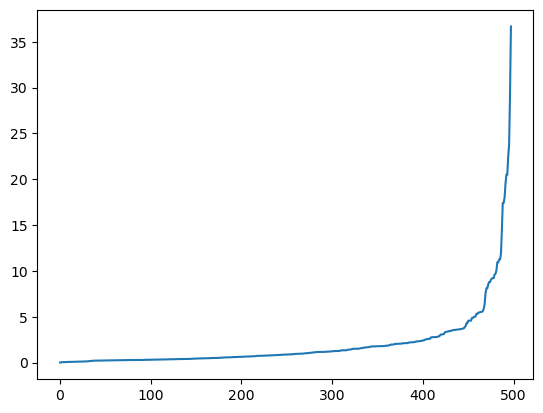

In [70]:
nbor= NearestNeighbors(n_neighbors= 2)
nborFit= nbor.fit(xformyDF)

dist, indexes= nborFit.kneighbors(xformyDF )
dist= np.sort(dist, axis= 0)
dist= dist[:,1]

plt.plot(dist)

In [72]:
sseForKmeans = int( len(yformyDF) * mean_squared_error(yformyDF, kmeanPredict ))
print(sseForKmeans)

2644


In [74]:
sseForDbscan= int( len(yformyDF) * mean_squared_error(yformyDF, dbscanPredict) )
print(sseForDbscan)

2414


In [75]:
kmMatrix= [] 
kmMatrix= np.ndarray(shape= (7,7), dtype= np.intc )

binV= [i for i in range(1,8) ]

for x in range(0, len(kmeanPredict)):
    pLe= kmeanPredict[x]
    if pLe not in binV:
        pLe= 7    
    kmMatrix[pLe - 1][int( yformyDF[x]) - 1]+= 1 
print(kmMatrix)

[[51 92 75 49 23  8  2]
 [ 9 16 11  2  1  1  0]
 [19 27 18  7  8  0  0]
 [ 1  3  3  0  0  0  0]
 [11 13 10  8  0  1  1]
 [ 4  4  5  1  0  0  0]
 [ 8  1  5  0  0  0  0]]


In [78]:
dbMatrix= []
dbMatrix= np.ndarray(shape= (7,7), dtype= np.intc)

for x in range(0,len(dbscanPredict)):
    pLe= dbscanPredict[x]
    if pLe not in binV:
        pLe= 7    
    dbMatrix[pLe - 1][int( yformyDF[x] ) - 1] += 1
    
print(dbMatrix)


[[ 89 146 114  65  32  10   3]
 [  2   1   3   0   0   0   0]
 [  0   1   0   1   0   0   0]
 [  1   1   1   0   0   0   0]
 [  0   2   0   0   0   0   0]
 [  3   1   1   0   0   0   0]
 [  8   4   8   1   0   0   0]]


In [80]:
trueMatrix= []
trueMatrix= np.ndarray(shape= (7,7), dtype= np.intc )

for x in range(0, len(yformyDF) ):
    pLe= int(yformyDF[x])    
    trueMatrix[pLe - 1][int(yformyDF[x])  - 1] += 1
print(trueMatrix)

[[103   0   0   0   0   0   0]
 [  0 156   0   0   0   0   0]
 [  0   0 127   0   0   0   0]
 [  0   0   0  67   0   0   0]
 [  0   0   0   0  32   0   0]
 [  0   0   0   0   0  10   0]
 [  0   0   0   0   0   0   3]]


In [81]:
from sklearn.metrics.cluster import homogeneity_score

kMeanEntropy= homogeneity_score(yformyDF, kmeanPredict )
print(kMeanEntropy)

0.032465165164888336


In [82]:
myList2= 0

for r in kmMatrix:
    sVal= 0
    rTot= np.sum(r)
    
    for ob in r:
        if ob != 0:
            sVal += -(ob/ rTot) * np.log2(ob/ rTot)
    myList2 += rTot * sVal
kMeanEntropy2= myList2 / np.sum(kmMatrix)
print(kMeanEntropy2)

2.2243267637575337


In [84]:
dbEntropy= homogeneity_score(yformyDF, dbscanPredict )

print(dbEntropy)

0.020827539192678674


In [86]:
myList3= 0

for r in dbMatrix:
    sVal= 0
    rTot= np.sum(r)
    for ob in r:
        if ob != 0:
            sVal += -(ob/ rTot) * np.log2(ob/ rTot)
    myList3 += rTot * sVal
dbEntropy2= myList3 / np.sum(dbMatrix)
print(dbEntropy2)

2.2546381578649255


In [94]:
myList4= 0
for r in kmMatrix:
    sVal= []
    rTot = np.sum(r)
    
   # print(rTot)
    for ob in r:
        sVal.append(ob/rTot )
   # print(sVal)
    #print(max(sVal ))
    
    myList4 += rTot * max(sVal)
    
kmPurity= myList4 / np.sum(kmMatrix)

print(kmPurity)

0.3293172690763052


In [91]:
myList5= 0
for r in dbMatrix:
    sVal= []
    rTot = np.sum(r)
    
    for ob in r:
        sVal.append(ob/rTot )
        
    #print(sVal )
    #print(max(sVal ))
    
    myList5 += rTot * max(sVal)
dbPurity= myList5 /  np.sum(dbMatrix )

print(dbPurity)


0.3293172690763052


In [92]:
import csv

#sseForKmeans= 2644
#sseForDbscan= 2414
#kMeanEntropy2= 2.2243267637575337
#dbEntropy2= 2.2546381578649255
#kmPurity= 0.3293172690763052
#dbPurity= 0.3293172690763052


f= open('./Result.csv', 'w')
w= csv.writer(f)
w.writerow([sseForKmeans, sseForDbscan, kMeanEntropy2, dbEntropy2, kmPurity, dbPurity])

f.close()